# Final Update:

In [6]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import joblib

FOLDER = 'filtered_centered'  
IMAGE_SIZE = (64, 64)  
MODEL_PATH = 'GroupB_Updated_SVM.joblib'
MAX_IMAGES = 1000

def detect_green_or_blue_lane_center(image):
    h, w, _ = image.shape
    bottom_quarter = image[int(0.75*h):, :]
    hsv = cv2.cvtColor(bottom_quarter, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])
    lower_blue  = np.array([85, 10, 150])
    upper_blue  = np.array([115, 150, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    mask = cv2.bitwise_or(mask_green, mask_blue)
    coords = np.column_stack(np.where(mask > 0))
    if coords.size == 0:
        lane_center = None
    else:
        lane_center = int(np.mean(coords[:, 1]))
    img_width = bottom_quarter.shape[1]
    return lane_center, img_width, mask

def classify_lane_position(lane_center, img_width, threshold=0.05):
    if lane_center is None:
        return 0.0
    center_x = img_width // 2
    delta = lane_center - center_x
    norm_delta = delta / img_width  
    if norm_delta < -threshold:
        return -1.0
    elif norm_delta > threshold:
        return 1.0
    else:
        return 0.0

images = [f for f in os.listdir(FOLDER) if f.lower().endswith('.png')]
images.sort()
print(f"Found {len(images)} images, using up to {MAX_IMAGES}.")

data = []
for idx, fname in enumerate(images[:MAX_IMAGES]):
    img_path = os.path.join(FOLDER, fname)
    img = cv2.imread(img_path)
    if img is None:
        print(f"[{idx+1}] Failed to load {fname}")
        continue
    h, w, _ = img.shape
    bottom_quarter = img[int(0.75*h):, :]
    lane_center, img_width, mask = detect_green_or_blue_lane_center(img)
    label = classify_lane_position(lane_center, img_width, threshold=0.05)
    mask_resized = cv2.resize(mask, IMAGE_SIZE)
    mask_flat = mask_resized.flatten()
    data.append({'frame': fname, 'image': mask_flat, 'label': float(label)})

if not data:
    raise ValueError("No valid images found or no labels detected.")

# --- MEMORY-EFFICIENT DATA HANDLING ---
X = np.stack([entry['image'] for entry in data])
y = np.array([entry['label'] for entry in data])

# Shuffle the data only once
X, y = shuffle(X, y, random_state=42)

# Split data (if less than 200 test samples, use 20%)
test_size = min(200, int(0.2 * len(X)))
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training label counts:", {v: int((y_train == v).sum()) for v in np.unique(y_train)})
print("Test label counts:", {v: int((y_test == v).sum()) for v in np.unique(y_test)})

# --- Train SVM ---
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', class_weight='balanced', verbose=True, max_iter=2000))
print("Training SVM on MASK features, 64x64...")
clf.fit(X_train, y_train)
joblib.dump(clf, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Found 2224 images, using up to 1000.
Training data shape: (800, 4096)
Test data shape: (200, 4096)
Training label counts: {np.float64(-1.0): 283, np.float64(0.0): 294, np.float64(1.0): 223}
Test label counts: {np.float64(-1.0): 64, np.float64(0.0): 77, np.float64(1.0): 59}
Training SVM on MASK features, 64x64...
[LibSVM]Model saved to GroupB_Updated_SVM.joblib


Test accuracy on 200 held-out images: 83.00%


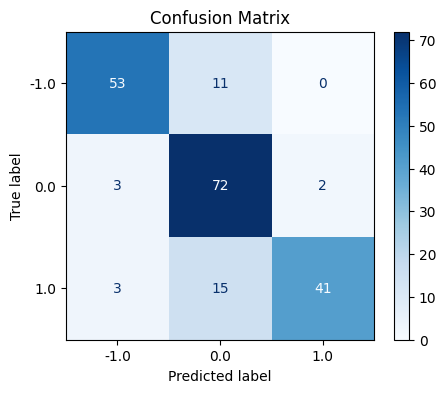

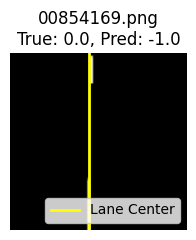

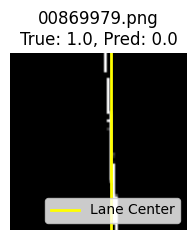

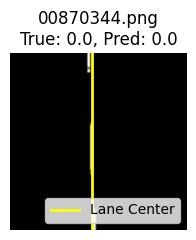

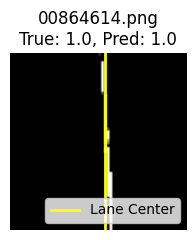

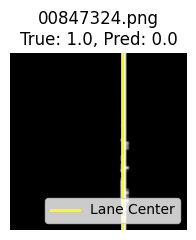

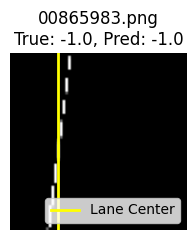

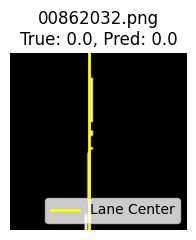

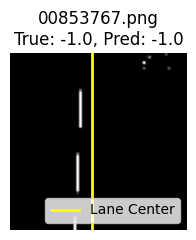

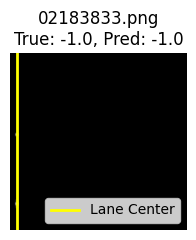

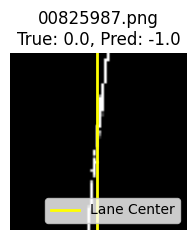

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Evaluate on test set ---
test_pred = clf.predict(X_test)
test_acc = np.mean(test_pred == y_test)
print(f"Test accuracy on {len(y_test)} held-out images: {test_acc * 100:.2f}%")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, test_pred, labels=[-1.0, 0.0, 1.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1.0, 0.0, 1.0])
plt.figure(figsize=(5,4))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

# --- Visualize 10 predictions ---
def get_lane_center(mask):
    coords = np.column_stack(np.where(mask > 0))
    lane_center = None
    if coords.size != 0:
        lane_center = int(np.mean(coords[:, 1]))
    return lane_center

selected = test_df.reset_index(drop=True).iloc[:10]
for idx, row in selected.iterrows():
    mask = row['image'].reshape(IMAGE_SIZE)
    lane_center = get_lane_center(mask)
    fname = row['frame']
    true_label = row['label']
    pred = test_pred[idx]
    plt.figure(figsize=(10,2.5))
    plt.imshow(mask, cmap='gray')
    if lane_center is not None:
        plt.axvline(lane_center, color='yellow', linewidth=2, label='Lane Center')
    plt.title(f"{fname}\nTrue: {true_label}, Pred: {pred}")
    plt.axis('off')
    if lane_center is not None:
        plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()